In [ ]:
from os import listdir
from pickle import dump  # Used to serialize and deserialize
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model


##Let's extract features from each image##
def featureExtracting(directory):
    model = VGG16()  ##Load the model##
    model.layers.pop()
    model = Model(model.inputs, model.layers[-1].output)  ##Let's remove the last layer##
    print(model.summary())
    ##extract features from images##
    features = dict()
    for name in listdir(directory):
        fileName = directory + '/' + name  ##Image path
        image = load_img(fileName, target_size=(224, 224))  ##Image load##
        image = img_to_array(image)  ##Convertion pixels to array##
        image = image.reshape(
            (1, image.shape[0], image.shape[1], image.shape[2]))  ##Time to reshape images from model##
        image = preprocess_input(image)  ##Time to prepare the image for VGG16 model##
        feature = model.predict(image, verbose=0)  ##Time to extract features##
        image_id = name.split(".")[0]
        # print(image_id) ##extract image id ##
        features[image_id] = feature
        print('>%s' % name)
    return features


directory = r"/content/drive/My Drive/imageCaption/Data/Flicker8k_Dataset"
features = featureExtracting(directory)
print('Extract feature  %d:' % len(features))
dump(features, open(r'/content/drive/My Drive/imageCaption/features.pkl', 'wb'))  ##Save the file##


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import string


##Let's load doc into memory##
def loadDoc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


# Let's extract description from the image#
def extractDescription(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        img_id, img_des = tokens[0], tokens[1:]  # First token as token id rest are description#
        # print(img_id)
        img_id = img_id.split('.')[0]
        # print(img_id)
        img_des = ' '.join(img_des)  # Let's combaine the tokens into description again ##
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping


def cleanDescription(description):
    ##Time to remove punctuation marks##
    table = str.maketrans('', '', string.punctuation)
    for key, descList in description.items():
        for i in range(len(descList)):
            desc = descList[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            descList[i] = ' '.join(desc)


# Let's convert the description into vocabulary of words#
def descToVocabulary(description):
    all_desc = set()
    for key in description.keys():
        [all_desc.update(d.split()) for d in description[key]]
    return all_desc


# let's save the description one per line#
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


##Let's declear the filename##
filename = r'/content/drive/My Drive/imageCaption/Flickr8k_text/Flickr8k.token.txt'
doc = loadDoc(filename)
description = extractDescription(doc)
print(f"Length of loaded descriptions {len(description)}")
cleanDescription(description)
vocabulary = descToVocabulary(description)
print(f"Size of vocabulary {len(vocabulary)}")
save_descriptions(description, r'/content/drive/My Drive/imageCaption/description.txt')


Length of loaded descriptions 8092
Size of vocabulary 8357


In [ ]:
from pickle import load


# Let's load doc into memory#

def loadDoc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


# Let's load the pre-defined list of photo identifier#
def loadSet(filename):
    doc = loadDoc(filename)

    dataset = list()

    for line in doc.split("\n"):

        tokens = line.split()  # Split by whitespace

        if len(line) < 2:
            continue
        identifier = line.split('.')[0]
        # print(f"identity:{identifier}")
        dataset.append(identifier)

    return set(dataset)


# Let's clean the description and load into memory#
def loadCleanDescription(filename, dataset):
    doc = loadDoc(filename)

    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        img_id, img_desc = tokens[0], tokens[1:]
        if img_id in dataset:
            if img_id not in descriptions:
                descriptions[img_id] = list()
            desc = 'stratseq ' + ' '.join(img_desc) + ' endseq'
            descriptions[img_id].append(desc)
    return descriptions


features = dict()


def load_photo_features(filename, dataset):
    count = 0
    features = dict()
    all_features = load(open(filename, 'rb'))
    # print(f"features {all_features}")
    try:
        for k in dataset:
            features.update({k: all_features[k]})
        # features = [{k: all_features[k]} for k in dataset]
    except Exception as e:
        # print(f"Exception {e}")
        count +=1
    return features


# Load training dataset#

filename = r'/content/drive/My Drive/imageCaption/Flickr8k_text/Flickr_8k.trainImages.txt'
train = loadSet(filename)
# print(train)
print('Dataset: %d' % len(train))
trainDescription = loadCleanDescription(r'/content/drive/My Drive/imageCaption/des.txt', train)
print('Description: train %d' % len(trainDescription))
# print(trainDescription)
train_features = load_photo_features(r'/content/drive/My Drive/imageCaption/features.pkl', train)
print('Photos train:%d' % len(train_features))

Dataset: 6000
Description: train 6000
Photos train:6000


In [ ]:
#Let's create a dictionary of clean description to a list description

def to_line(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
to_line(trainDescription)

['stratseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'stratseq girl going into wooden building endseq',
 'stratseq little girl climbing into wooden playhouse endseq',
 'stratseq little girl climbing the stairs to her playhouse endseq',
 'stratseq little girl in pink dress going into wooden cabin endseq',
 'stratseq black dog and spotted dog are fighting endseq',
 'stratseq black dog and tricolored dog playing with each other on the road endseq',
 'stratseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'stratseq two dogs of different breeds looking at each other on the road endseq',
 'stratseq two dogs on pavement moving toward each other endseq',
 'stratseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'stratseq little girl is sitting in front of large painted rainbow endseq',
 'stratseq small girl in the grass plays with fingerpaints in front of white canvas w

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#Let's fit a tokenizer given description

def create_tokenizer(descriptions):
    lines = to_line(descriptions)
    tokenizers = Tokenizer()
    tokenizers.fit_on_texts(lines)
    return tokenizers#Let's fit a tokenizer given description


In [ ]:
tokenizer = create_tokenizer(trainDescription)
#Let's get the size


In [ ]:
import tensorflow as tf

In [ ]:
!pip install keras=='2.2.4'

In [ ]:
!pip install tensorflow=='1.13.1'

     |████████████████████████████████| 92.6MB 93kB/s 
     |████████████████████████████████| 3.2MB 37.7MB/s 
     |████████████████████████████████| 368kB 41.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
from numpy import array
import tensorflow as tf
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [ ]:

tf.__version__

'1.13.1'

In [ ]:
# create sequences of images, input sequences and output words for an image
import numpy as np
vocab_size = len(tokenizer.word_index)+1
vocab_size
def create_sequences(tokenizer, max_length, desc_list,vocab_size, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
      # photo = photo.reshape(4096,1)
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
   
	return np.asarray(X1), np.asarray(X2), np.asarray(y)

In [ ]:
#Let's get the length of the description with most words
def max_length(descriptions):
    lines = to_line(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
max_length = max_length(trainDescription)

In [ ]:
max_length

34

In [ ]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
 
	# summarize model
	print(model.summary())
	return model

In [ ]:
#Progressive loading of data
def data_generator(descriptions,photos,tokenizer,max_length,vocab_size):
    for i in range(20):
        for key,desc_list in descriptions.items():
            photo = photos[key][0]
            inImg,inSeq,outWord = create_sequences(tokenizer,max_length,desc_list,vocab_size,photo)
            yield [[inImg, inSeq], outWord]
            # print('ok')
            


In [ ]:
#Let's training dataset
filename = '/content/drive/My Drive/imageCaption/Flickr8k_text/Flickr_8k.trainImages.txt'
train = loadSet(filename)
# print(train)
print('Dataset: %d' % len(train))
trainDescription = loadCleanDescription('/content/drive/My Drive/imageCaption/des.txt', train)
print('Description: train %d' % len(trainDescription))
# print(trainDescription)
train_features = load_photo_features('/content/drive/My Drive/imageCaption/features.pkl', train)
print('Photos train:%d' % len(train_features))
tokenizer = create_tokenizer(trainDescription)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
# max_length = max_length(trainDescription)
print('Description Length: %d' % max_length)
# X1train, X2train, ytrain = create_sequences(tokenizer, max_length, trainDescription, vocab_size,train_features)
# print(X1train)

Dataset: 6000
Description: train 6000
Photos train:6000
Vocabulary Size: 7579
Description Length: 34


In [ ]:

input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_length,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# train the model
# model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 2
steps = len(trainDescription)
print(steps)
for i in range(epochs):
  # print('in')
	# create the data generator
	generator= data_generator(trainDescription, train_features, tokenizer, max_length,vocab_size)
  # print("generator")
	# fit for one epoch
	model.fit_generator(generator, epochs=1,steps_per_epoch=steps,verbose=1)
#  print("Runed")
	# save model
	model.save('/content/drive/My Drive/imageCaption/model_' + str(i) + '.h5')

In [ ]:

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare training set

# load training dataset (6K)
filename = '/content/drive/MyDrive/imageCaption/Flickr8k_text/Flickr_8k.trainImages.txt'
train = loadSet(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = loadCleanDescription('/content/drive/MyDrive/imageCaption/des.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
# max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = '/content/drive/MyDrive/imageCaption/Flickr8k_text/Flickr_8k.testImages.txt'
test = loadSet(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = loadCleanDescription('/content/drive/MyDrive/imageCaption/des.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/MyDrive/imageCaption/features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model which has minimum loss, in this case it was model_18
filename = '/content/drive/MyDrive/imageCaption/model/model_18.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.380334
BLEU-2: 0.174301
BLEU-3: 0.114755
BLEU-4: 0.046723


In [ ]:
test

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


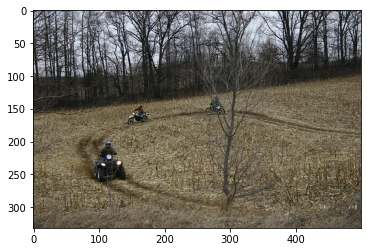

Generated Caption:man in red shirt is riding bike on the street


In [ ]:
#Generate Captions for a Fresh Image


from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
tokenizer = load(open('/content/drive/MyDrive/imageCaption/model/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('/content/drive/MyDrive/imageCaption/model/model_18.h5')
# load and prepare the photograph
photo = extract_features('/content/drive/MyDrive/imageCaption/Data/Flicker8k_Dataset/112243673_fd68255217.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/imageCaption/Data/Flicker8k_Dataset/112243673_fd68255217.jpg')
imgplot = plt.imshow(img)
plt.show()
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print("Generated Caption:"+result)
# path = '/content/drive/MyDrive/imageCaption/Flickr8k_text/Flickr_8k.trainImages.txt'
# doc = loadDoc(path)
# descriptions = dict()
# for line in doc.split('\n'):
#     tokens = line.split()
#     img_id, img_desc = tokens[0], tokens[1:]
#     if img_id in train:
#         if img_id not in descriptions:
#             descriptions['img_id'] = list()
#         desc = 'stratseq ' + ' '.join(img_desc) + ' endseq'
#         descriptions[img_id].append(desc)
# # return descriptions
# print(description)

In [ ]:
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
directory = r"/content/drive/My Drive/imageCaption/Data/Flicker8k_Dataset"
# load the model
modl = load_model('/content/drive/MyDrive/imageCaption/model/model_18.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in description.items() if image in test])
max_length = 34

for count in range(10):
    photo = extract_feat('{}.jpg'.format(directory+'/'+test[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", description[test[count]])
    print('*********************************************************************')
    print()